In [1]:
from imports import plt, np, pd, rfft, rfftfreq, irfft, lombscargle, TimeSeriesSplit, tf, sns
import data_processing

2024-03-20 13:17:24.147534: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 13:17:24.147583: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 13:17:24.148490: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-20 13:17:24.154848: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 13:17:24.792532: W tensorflow/compiler/tf2

Read in the data with the read.data() function from data_processing.py

In [2]:
sunspots = data_processing.read_data()
sunspots

,Greg_Year,Month,Dec_Year,N_total_sunspots_smoothed,Montly_mean_sunspot_number_std,N_obs,Marker
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1
...,...,...,...,...,...,...,...
3297,2023,10,2023.790,99.4,16.0,958,0
3298,2023,11,2023.873,105.4,16.7,809,0
3299,2023,12,2023.958,114.2,17.9,619,0
3300,2024,1,2024.042,123.0,18.7,783,0


Take a look at the given sunspots data

[Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Number of sunspots'),
 Text(0.5, 1.0, 'Monthly averaged number of sunspots')]

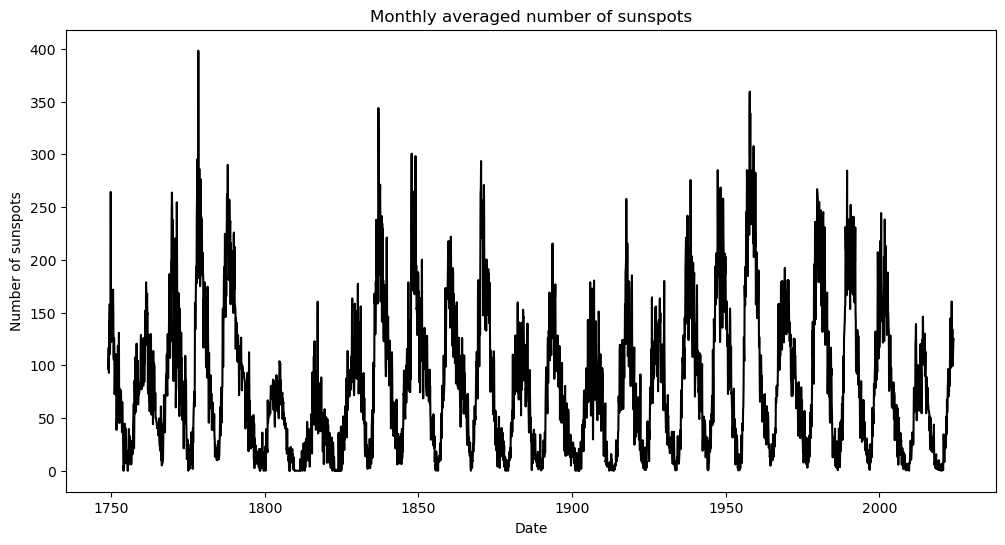

In [3]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(sunspots['Dec_Year'], sunspots['N_total_sunspots_smoothed'], 'k-')
ax.set(
    xlabel='Date',
    ylabel='Number of sunspots',
    title='Monthly averaged number of sunspots',
)

Now the data looks like being some kind of periodic\
We use Lomb-Scargle-Periodogram to learn about the frequencies of the given data\
As we can see, the period is ~11 years

Frequency with highest amplitude: 0.09053884883096722
Period: 11.044982489969186


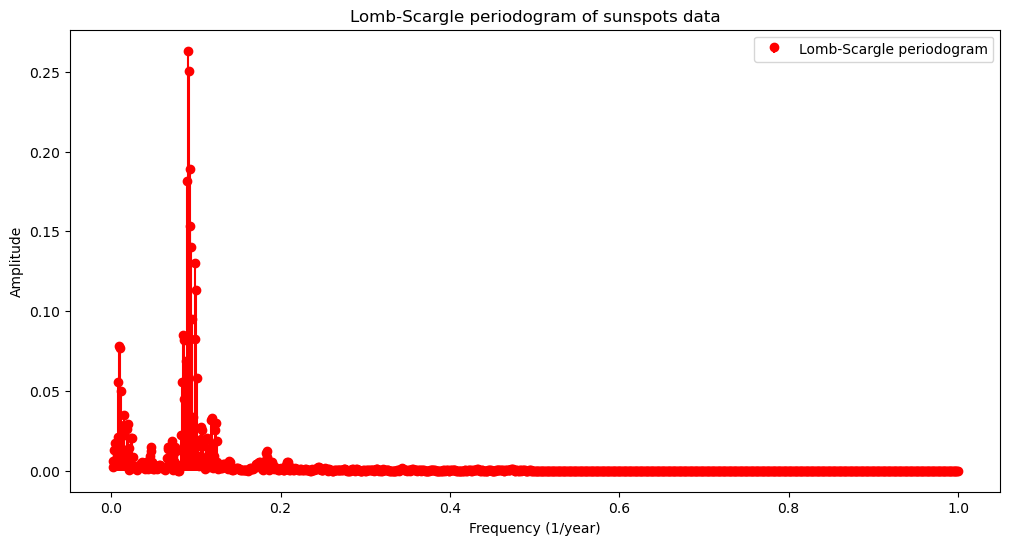

In [23]:
freq_periodogram = np.linspace(0.01, 2*np.pi, 1000)
periodogram = lombscargle(sunspots['Dec_Year']-sunspots['Dec_Year'].iloc[0], 
                    sunspots['N_total_sunspots_smoothed']-np.mean(sunspots['N_total_sunspots_smoothed']), 
                    freq_periodogram, normalize=True)

fig, ax = plt.subplots(figsize=(12, 6))

ax.stem(freq_periodogram/(2*np.pi), periodogram, 'r', label='Lomb-Scargle periodogram', basefmt="none")
ax.set(
    xlabel='Frequency (1/year)',
    ylabel='Amplitude',
    title='Lomb-Scargle periodogram of sunspots data',
)
plt.legend()
print('Frequency with highest amplitude:', freq_periodogram[np.argmax(periodogram)]/(2*np.pi))
print('Period:', 1/(freq_periodogram[np.argmax(periodogram)]/(2*np.pi)))

Now filter high frequencies (Fluctuations)\
This is done using Fourier-Transform

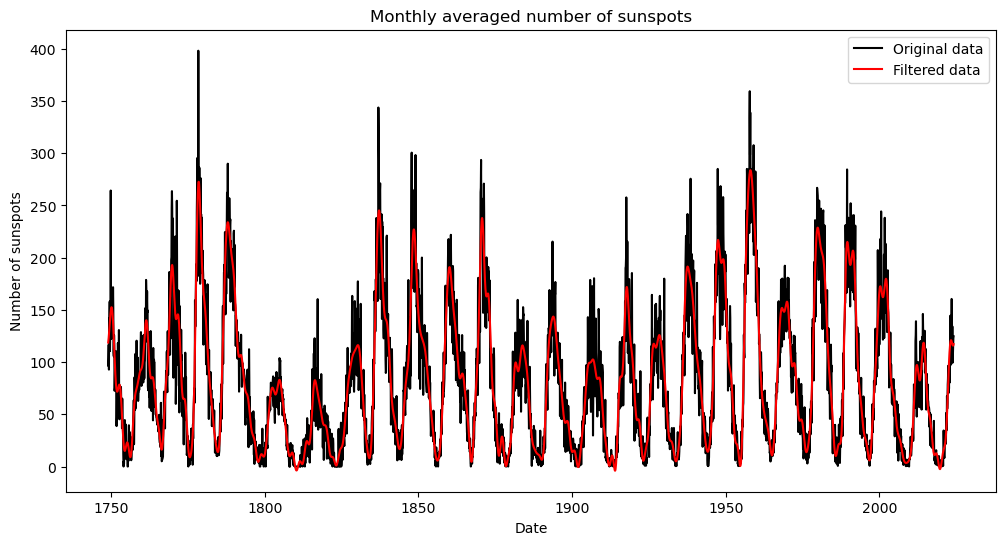

In [5]:
sunspots_filtered = data_processing.filter_data(df = sunspots, treshold = 0.5, x = 'Dec_Year', y = 'N_total_sunspots_smoothed')

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(sunspots['Dec_Year'], sunspots['N_total_sunspots_smoothed'], 'k-', label='Original data')
ax.plot(sunspots['Dec_Year'], sunspots_filtered, 'r-', label='Filtered data')
ax.set(
    xlabel='Date',
    ylabel='Number of sunspots',
    title='Monthly averaged number of sunspots',
)
plt.legend()

In [6]:
sunspots['N_total_sunspots_smoothed'] = sunspots_filtered
sunspots = sunspots[['Dec_Year', 'N_total_sunspots_smoothed']]
num_features = sunspots.shape[1]

Split the data into training and test set and standardize it

In [7]:
train_set, test_set = data_processing.split_data(sunspots)
train_set, test_set = data_processing.standardize_data(train_set, test_set)

/home/lennart/Git Projekte/sunspot_data/scripts/data_processing.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['N_total_sunspots_smoothed'] = (train['N_total_sunspots_smoothed'] - mean) / std
/home/lennart/Git Projekte/sunspot_data/scripts/data_processing.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['N_total_sunspots_smoothed'] = (test['N_total_sunspots_smoothed'] - mean) / std


Now it is important to window the data\
We want to do multi-step-prediction, so we use a multi-window with a with output width of 100

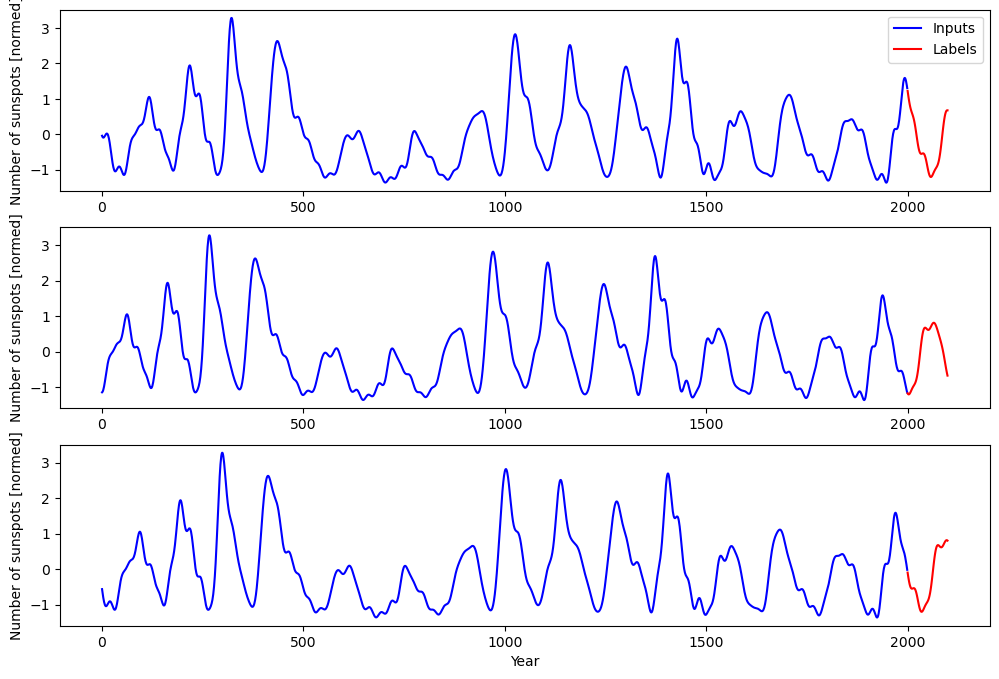

In [15]:
out_steps = 100

multi_window = data_processing.window_generator(input_width=2000, label_width=out_steps, shift=out_steps, train_df=train_set, test_df=test_set, label_columns=['N_total_sunspots_smoothed'])

window = tf.stack([np.array(train_set[:multi_window.total_window_size]), np.array(train_set[200:200+multi_window.total_window_size])])

inputs, labels = multi_window.split_window(window)

multi_window.plot()

Epoch 1/500
7/7 [==============================] - 0s 7ms/step - loss: 1.0722 - mse: 1.7152 - mae: 1.0722
Epoch 2/500
7/7 [==============================] - 0s 8ms/step - loss: 0.8585 - mse: 1.1398 - mae: 0.8585
Epoch 3/500
7/7 [==============================] - 0s 7ms/step - loss: 0.8422 - mse: 1.0658 - mae: 0.8422
Epoch 4/500
7/7 [==============================] - 0s 7ms/step - loss: 0.7851 - mse: 0.8824 - mae: 0.7851
Epoch 5/500
7/7 [==============================] - 0s 7ms/step - loss: 0.7687 - mse: 0.8652 - mae: 0.7687
Epoch 6/500
7/7 [==============================] - 0s 8ms/step - loss: 0.7671 - mse: 0.7959 - mae: 0.7671
Epoch 7/500
7/7 [==============================] - 0s 5ms/step - loss: 0.7600 - mse: 0.8350 - mae: 0.7600
Epoch 8/500
7/7 [==============================] - 0s 5ms/step - loss: 0.7676 - mse: 0.8275 - mae: 0.7676
Epoch 9/500
7/7 [==============================] - 0s 5ms/step - loss: 0.7681 - mse: 0.8420 - mae: 0.7681
Epoch 10/500
7/7 [============================

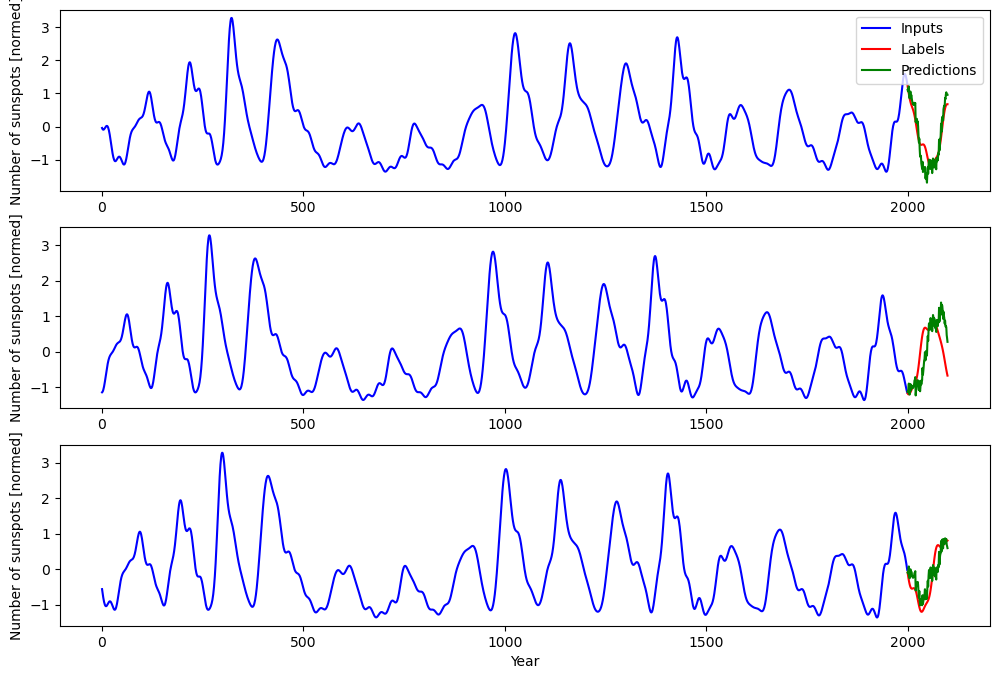

In [16]:
linear_model = data_processing.linear_model(outer_steps=out_steps)

history = data_processing.compile_and_fit(linear_model, multi_window, lr = 0.001, momentum = 0.9, patience=20)

multi_window.plot(linear_model)

Epoch 1/500
7/7 [==============================] - 1s 16ms/step - loss: 17.0463 - mse: 436.2791 - mae: 17.0463
Epoch 2/500
7/7 [==============================] - 0s 13ms/step - loss: 9.0338 - mse: 119.9327 - mae: 9.0338
Epoch 3/500
7/7 [==============================] - 0s 10ms/step - loss: 5.4412 - mse: 47.6442 - mae: 5.4412
Epoch 4/500
7/7 [==============================] - 0s 8ms/step - loss: 3.3330 - mse: 17.9606 - mae: 3.3330
Epoch 5/500
7/7 [==============================] - 0s 7ms/step - loss: 2.2803 - mse: 7.8955 - mae: 2.2803
Epoch 6/500
7/7 [==============================] - 0s 7ms/step - loss: 1.6028 - mse: 3.8956 - mae: 1.6028
Epoch 7/500
7/7 [==============================] - 0s 6ms/step - loss: 1.2035 - mse: 2.2440 - mae: 1.2035
Epoch 8/500
7/7 [==============================] - 0s 6ms/step - loss: 1.0187 - mse: 1.5718 - mae: 1.0187
Epoch 9/500
7/7 [==============================] - 0s 6ms/step - loss: 0.9063 - mse: 1.2451 - mae: 0.9063
Epoch 10/500
7/7 [=================

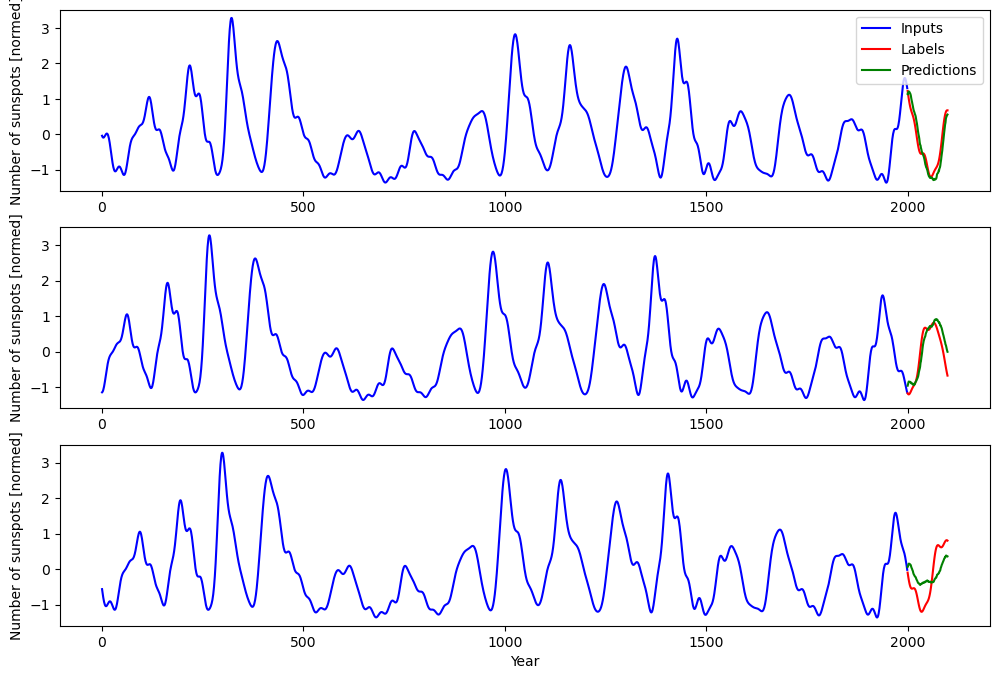

In [17]:
dense_model = data_processing.dense_model(outer_steps=out_steps)

history = data_processing.compile_and_fit(dense_model, multi_window, lr = 0.001, momentum = 0.9, patience=40)

multi_window.plot(dense_model)

As shown above, a linear and a dense model is trained on the given input data and used to do a prediction\
Both models work quite well